In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Display plots inline
%matplotlib inline

In [21]:
df = pd.read_csv(
    "statcast_pitch_swing_data_20240402_20241030_with_arm_angle.csv",
    parse_dates=["game_date"],          # add other date cols if present
    low_memory=False
)

# Optional: enforce expected dtypes (adjust if your columns differ)
num_cols_expect = [
    "bat_speed","swing_length","arm_angle","release_speed","effective_speed",
    "plate_x","plate_z","launch_speed","launch_angle","balls","strikes",
    "outs_when_up"
]
for c in num_cols_expect:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

cat_cols_expect = ["description","pitch_type","zone","stand","p_throws","inning_topbot"]
for c in cat_cols_expect:
    if c in df.columns:
        df[c] = df[c].astype("category")

df.head(3)

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,n_thruorder_pitcher,n_priorpa_thisgame_player_at_bat,pitcher_days_since_prev_game,batter_days_since_prev_game,pitcher_days_until_next_game,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle
0,FF,2024-04-02,95.0,-2.01,5.22,"Rocchio, Brayan",677587,622491,single,hit_into_play,...,3,2,5.0,1.0,6.0,1.0,1.32,0.85,-0.85,19.4
1,CH,2024-04-02,88.5,-2.09,4.95,"Rocchio, Brayan",677587,622491,NaN,foul,...,3,2,5.0,1.0,6.0,1.0,2.82,1.40,-1.40,14.4
2,SI,2024-04-02,95.0,-2.02,5.12,"Rocchio, Brayan",677587,622491,NaN,called_strike,...,3,2,5.0,1.0,6.0,1.0,2.37,1.48,-1.48,21.9


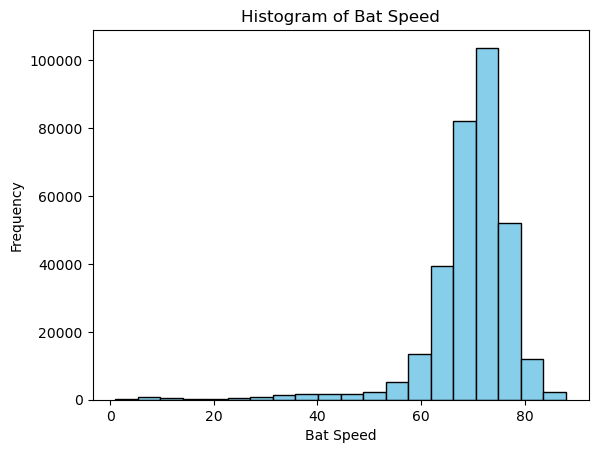

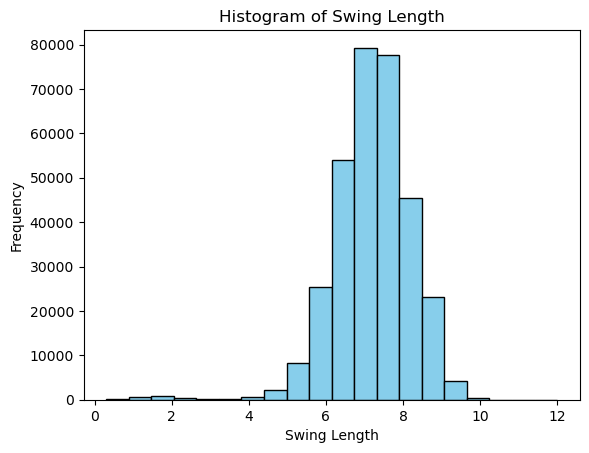

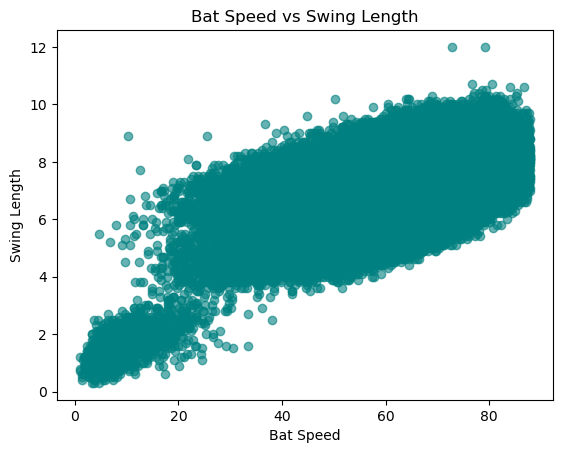

In [22]:
#Histogram of Bat Speed
plt.hist(df['bat_speed'], bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of Bat Speed')
plt.xlabel('Bat Speed')
plt.ylabel('Frequency')
plt.show()

#Histogram of Swing Length
plt.hist(df['swing_length'], bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of Swing Length')
plt.xlabel('Swing Length')
plt.ylabel('Frequency')
plt.show()

#Scatter plot comparing Swing Length and Bat Speed
plt.scatter(df['bat_speed'], df['swing_length'], alpha=0.6, color='teal')
plt.title('Bat Speed vs Swing Length')
plt.xlabel('Bat Speed')
plt.ylabel('Swing Length')
plt.show()

In [41]:
#Create and define subsets for whiffs and hard hits

#Subset of Strings
swings = df[df['description'].isin([
    'foul', 'foul_tip', 'hit_into_play', 'swinging_strike', 'swinging_strike_blocked'
])].copy()

#Whiffs
swings.loc[:, 'y_whiff'] = swings['description'].isin(['swinging_strike', 'swinging_strike_blocked']).astype(int)
whiff_counts = swings['y_whiff'].value_counts()
print(whiff_counts)
print("\nClass balance for y_whiff:")
print(f"Whiffs (misses): {whiff_counts[1]} ({whiff_counts[1]/len(swings):.1%})")
print(f"Contacts: {whiff_counts[0]} ({whiff_counts[0]/len(swings):.1%})")
df.loc[:, 'y_whiff'] = df['description'].isin([
    'swinging_strike', 'swinging_strike_blocked'
]).astype(int)
#Subset of Contacts
contact = swings[
    swings['description'].isin(['foul', 'foul_tip', 'hit_into_play'])
    & swings['launch_speed'].notnull()
].copy()

#Hard hits
contact.loc[:, 'y_hardhit'] = (contact['launch_speed'] >= 95).astype(int) #speed above 95
hardhit_counts = contact['y_hardhit'].value_counts()
print(hardhit_counts)
print("\nClass balance for y_hardhit:")
print(f"Hard-hit: {hardhit_counts[1]} ({hardhit_counts[1]/len(contact):.1%})")
print(f"Not hard-hit: {hardhit_counts[0]} ({hardhit_counts[0]/len(contact):.1%})")
df.loc[:, 'y_hardhit'] = (contact['launch_speed'] >= 95).astype(int)

y_whiff
0    257403
1     77801
Name: count, dtype: int64

Class balance for y_whiff:
Whiffs (misses): 77801 (23.2%)
Contacts: 257403 (76.8%)
y_hardhit
0    179198
1     55832
Name: count, dtype: int64

Class balance for y_hardhit:
Hard-hit: 55832 (23.8%)
Not hard-hit: 179198 (76.2%)


In [42]:
num_features = [
    "bat_speed",         # how fast the bat moves
    "swing_length",      # how long the swing path is
    "arm_angle",         # hitter’s arm slot
    "release_speed",     # pitch velocity
    "effective_speed",   # perceived velocity
    "plate_x", "plate_z",# pitch location
    "balls", "strikes", "outs_when_up"
]

cat_features = [
    "pitch_type",    # e.g. fastball, slider, changeup
    "zone",          # numeric strike-zone area
    "stand",         # batter handedness
    "p_throws",      # pitcher handedness
    "inning_topbot"  # top/bottom of inning
]

df["bat_to_length_ratio"] = df["bat_speed"] / df["swing_length"]
df["bat_times_length"]    = df["bat_speed"] * df["swing_length"]

features = num_features + cat_features + ["bat_to_length_ratio","bat_times_length",'y_whiff',"y_hardhit"]
clean_df = df[features].copy()
clean_df.head(20)

,bat_speed,swing_length,arm_angle,release_speed,effective_speed,plate_x,plate_z,balls,strikes,outs_when_up,pitch_type,zone,stand,p_throws,inning_topbot,bat_to_length_ratio,bat_times_length,y_whiff,y_hardhit
0,NaN,NaN,19.4,95.0,93.5,0.69,3.18,0,2,2,FF,3.0,L,R,Top,NaN,NaN,0,0.0
1,NaN,NaN,14.4,88.5,87.4,-0.30,2.29,0,1,2,CH,4.0,L,R,Top,NaN,NaN,0,0.0
2,NaN,NaN,21.9,95.0,93.7,-0.14,3.15,0,0,2,SI,2.0,L,R,Top,NaN,NaN,0,NaN
3,NaN,NaN,36.3,80.8,81.1,-1.01,1.13,3,2,2,KC,13.0,L,R,Top,NaN,NaN,0,0.0
4,NaN,NaN,17.5,95.4,94.3,-0.04,2.52,1,2,1,FF,5.0,R,R,Top,NaN,NaN,0,NaN
5,NaN,NaN,27.9,90.7,91.0,-2.25,3.29,3,0,2,SI,11.0,L,R,Bot,NaN,NaN,0,NaN
6,NaN,NaN,23.9,91.8,91.0,-2.09,2.97,3,2,0,SI,11.0,L,L,Top,NaN,NaN,0,NaN
7,NaN,NaN,15.0,94.0,93.1,0.77,1.72,1,1,1,SI,9.0,R,R,Top,NaN,NaN,0,NaN
8,NaN,NaN,24.9,89.9,90.7,1.31,2.92,2,0,2,SI,12.0,L,R,Bot,NaN,NaN,0,NaN
9,NaN,NaN,40.0,93.4,94.6,-1.00,1.17,2,2,2,FF,13.0,L,R,Top,NaN,NaN,0,NaN


/tmp/ipykernel_580/2817370318.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  clean_df.groupby(['zone', 'bat_speed_tier'])['y_whiff']


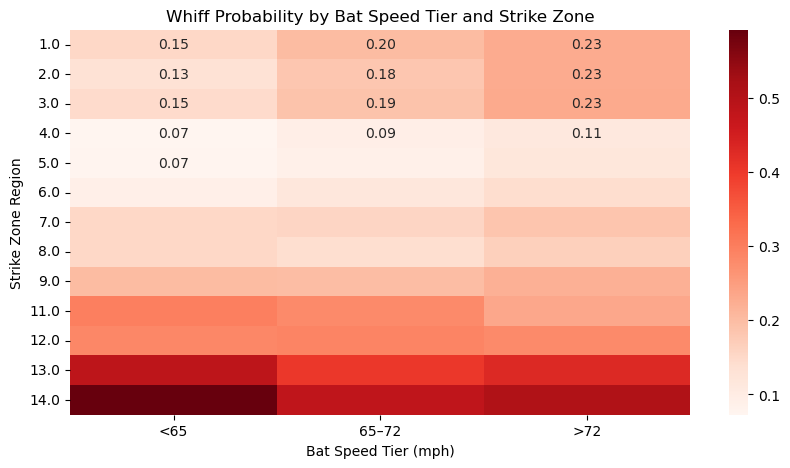

In [44]:
clean_df['bat_speed_tier'] = pd.cut(
    clean_df['bat_speed'],
    bins=[0, 65, 72, 100],
    labels=['<65', '65–72', '>72']
)

# Group by zone and tier
zone_whiff = (
    clean_df.groupby(['zone', 'bat_speed_tier'])['y_whiff']
    .mean()
    .reset_index()
)

# Plot as heatmap
zone_whiff_pivot = zone_whiff.pivot(
    index='zone',
    columns='bat_speed_tier',
    values='y_whiff'
)
plt.figure(figsize=(10, 5))
sns.heatmap(zone_whiff_pivot, annot=True, cmap='Reds', fmt=".2f")
plt.title('Whiff Probability by Bat Speed Tier and Strike Zone')
plt.xlabel('Bat Speed Tier (mph)')
plt.ylabel('Strike Zone Region')
plt.show()

/tmp/ipykernel_580/4240317713.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heat = clean_df.groupby(['bat_speed_bin', 'swing_length_bin'])['y_whiff'].mean().unstack()
/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


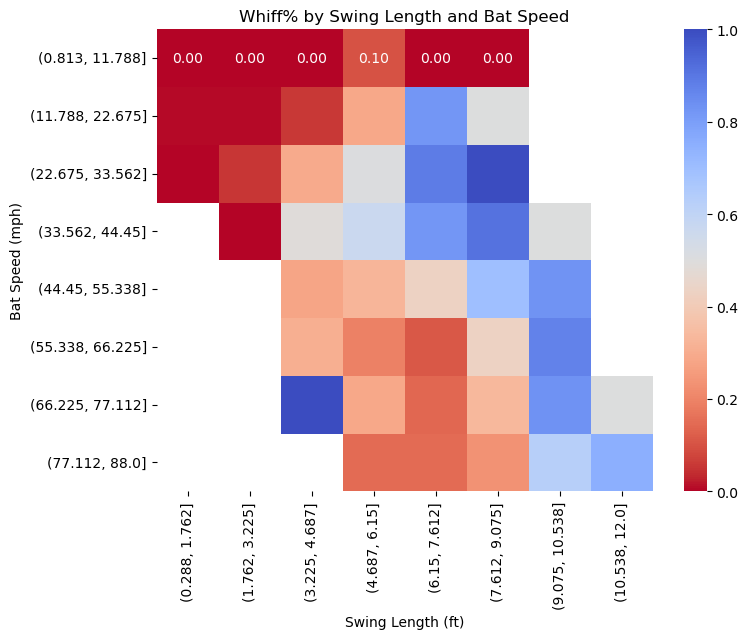

In [45]:
# Bin both bat_speed and swing_length
clean_df['bat_speed_bin'] = pd.cut(clean_df['bat_speed'], bins=8)
clean_df['swing_length_bin'] = pd.cut(clean_df['swing_length'], bins=8)

# Compute whiff rate
heat = clean_df.groupby(['bat_speed_bin', 'swing_length_bin'])['y_whiff'].mean().unstack()

# Plot 2D heatmap
plt.figure(figsize=(8,6))
sns.heatmap(heat, cmap='coolwarm_r', annot=True, fmt=".2f")
plt.title('Whiff% by Swing Length and Bat Speed')
plt.xlabel('Swing Length (ft)')
plt.ylabel('Bat Speed (mph)')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


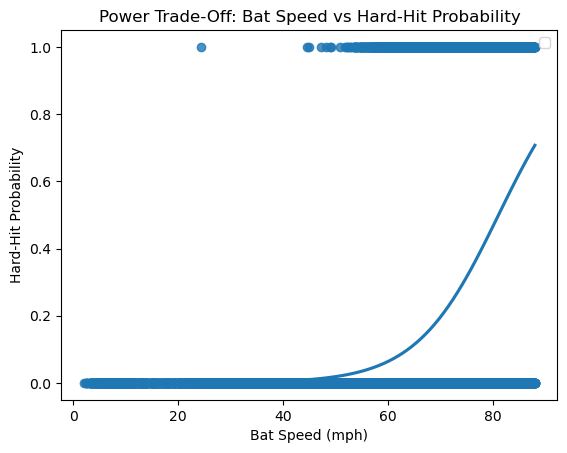

In [56]:
sns.regplot(data=clean_df, x='bat_speed', y='y_hardhit', logistic=True, ci=None)
plt.title('Power Trade-Off: Bat Speed vs Hard-Hit Probability')
plt.xlabel('Bat Speed (mph)')
plt.ylabel('Hard-Hit Probability')
plt.legend()
plt.show()

/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


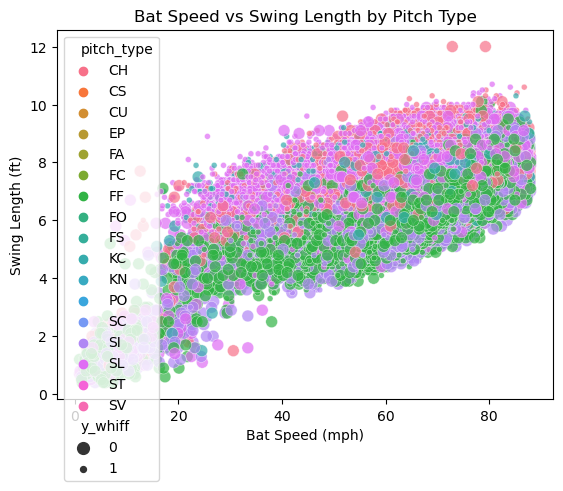

In [55]:
pitch_types = ['FF', 'CH', 'SI', 'KC', 'SL']
subset = clean_df[clean_df['pitch_type'].isin(pitch_types)]

sns.scatterplot(
    data=subset, x='bat_speed', y='swing_length',
    hue='pitch_type', size='y_whiff', alpha=0.7
)
plt.title('Bat Speed vs Swing Length by Pitch Type')
plt.xlabel('Bat Speed (mph)')
plt.ylabel('Swing Length (ft)')
plt.show()